In [33]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [3]:
! pwd

/home/yuri/github.com/AoesJP/project_pokereader/notebooks


In [4]:
PROJECT_PATH = Path(".").absolute().parent
PROJECT_PATH

PosixPath('/home/yuri/github.com/AoesJP/project_pokereader')

In [38]:
# img_path = str(PROJECT_PATH / "data/charizard.png")
img_path = str(PROJECT_PATH / "data/rectangles.png")
img_path

'/home/yuri/github.com/AoesJP/project_pokereader/data/rectangles.png'

In [39]:
BKG_THRESH = 60
CARD_MAX_AREA = 120000
CARD_MIN_AREA = 25000
font = cv2.FONT_HERSHEY_SIMPLEX

In [40]:
def preprocess_image(image):
    """Returns a grayed, blurred, and adaptively thresholded camera image."""

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # The best threshold level depends on the ambient lighting conditions.
    # For bright lighting, a high threshold must be used to isolate the cards
    # from the background. For dim lighting, a low threshold must be used.
    # To make the card detector independent of lighting conditions, the
    # following adaptive threshold method is used.
    #
    # A background pixel in the center top of the image is sampled to determine
    # its intensity. The adaptive threshold is set at 50 (THRESH_ADDER) higher
    # than that. This allows the threshold to adapt to the lighting conditions.
    img_w, img_h = np.shape(image)[:2]
    bkg_level = gray[int(img_h / 100)][int(img_w / 2)]
    thresh_level = bkg_level + BKG_THRESH

    retval, thresh = cv2.threshold(blur, thresh_level, 255, cv2.THRESH_BINARY)

    return thresh

In [41]:
def find_cards(thresh_image):
    """Finds all card-sized contours in a thresholded camera image.
    Returns the number of cards, and a list of card contours sorted
    from largest to smallest."""

    # Find contours and sort their indices by contour size
    # dummy, cnts, hier = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts, hier = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(cnts)), key=lambda i: cv2.contourArea(cnts[i]), reverse=True)

    # If there are no contours, do nothing
    if len(cnts) == 0:
        return [], []

    # Otherwise, initialize empty sorted contour and hierarchy lists
    cnts_sort = []
    hier_sort = []
    cnt_is_card = np.zeros(len(cnts), dtype=int)

    # Fill empty lists with sorted contour and sorted hierarchy. Now,
    # the indices of the contour list still correspond with those of
    # the hierarchy list. The hierarchy array can be used to check if
    # the contours have parents or not.
    for i in index_sort:
        cnts_sort.append(cnts[i])
        hier_sort.append(hier[0][i])

    # Determine which of the contours are cards by applying the
    # following criteria: 1) Smaller area than the maximum card size,
    # 2), bigger area than the minimum card size, 3) have no parents,
    # and 4) have four corners

    for i in range(len(cnts_sort)):
        size = cv2.contourArea(cnts_sort[i])
        peri = cv2.arcLength(cnts_sort[i], True)
        approx = cv2.approxPolyDP(cnts_sort[i], 0.01 * peri, True)

        if (
            (size < CARD_MAX_AREA)
            and (size > CARD_MIN_AREA)
            and (hier_sort[i][3] == -1)
            and (len(approx) == 4)
        ):
            cnt_is_card[i] = 1

    return cnts_sort, cnt_is_card

In [42]:
def draw_results(image, qCard):
    """Draw the card name, center point, and contour on the camera image."""

    x = qCard.center[0]
    y = qCard.center[1]
    cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

    rank_name = qCard.best_rank_match
    suit_name = qCard.best_suit_match

    # Draw card name twice, so letters have black outline
    cv2.putText(image, (rank_name + " of"), (x - 60, y - 10), font, 1, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(
        image, (rank_name + " of"), (x - 60, y - 10), font, 1, (50, 200, 200), 2, cv2.LINE_AA
    )

    cv2.putText(image, suit_name, (x - 60, y + 25), font, 1, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(image, suit_name, (x - 60, y + 25), font, 1, (50, 200, 200), 2, cv2.LINE_AA)

    # Can draw difference value for troubleshooting purposes
    # (commented out during normal operation)
    # r_diff = str(qCard.rank_diff)
    # s_diff = str(qCard.suit_diff)
    # cv2.putText(image,r_diff,(x+20,y+30),font,0.5,(0,0,255),1,cv2.LINE_AA)
    # cv2.putText(image,s_diff,(x+20,y+50),font,0.5,(0,0,255),1,cv2.LINE_AA)

    return image

In [10]:
def preprocess_card(contour, image):
    """Uses contour to find information about the query card. Isolates rank
    and suit images from the card."""

    # Initialize new Query_card object
    qCard = Query_card()

    qCard.contour = contour

    # Find perimeter of card and use it to approximate corner points
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.01 * peri, True)
    pts = np.float32(approx)
    qCard.corner_pts = pts

    # Find width and height of card's bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    qCard.width, qCard.height = w, h

    # Find center point of card by taking x and y average of the four corners.
    average = np.sum(pts, axis=0) / len(pts)
    cent_x = int(average[0][0])
    cent_y = int(average[0][1])
    qCard.center = [cent_x, cent_y]

    # Warp card into 200x300 flattened image using perspective transform
    qCard.warp = flattener(image, pts, w, h)

    # Grab corner of warped card image and do a 4x zoom
    Qcorner = qCard.warp[0:CORNER_HEIGHT, 0:CORNER_WIDTH]
    Qcorner_zoom = cv2.resize(Qcorner, (0, 0), fx=4, fy=4)

    # Sample known white pixel intensity to determine good threshold level
    white_level = Qcorner_zoom[15, int((CORNER_WIDTH * 4) / 2)]
    thresh_level = white_level - CARD_THRESH
    if thresh_level <= 0:
        thresh_level = 1
    retval, query_thresh = cv2.threshold(Qcorner_zoom, thresh_level, 255, cv2.THRESH_BINARY_INV)

    # Split in to top and bottom half (top shows rank, bottom shows suit)
    Qrank = query_thresh[20:185, 0:128]
    Qsuit = query_thresh[186:336, 0:128]

    # Find rank contour and bounding rectangle, isolate and find largest contour
    dummy, Qrank_cnts, hier = cv2.findContours(Qrank, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    Qrank_cnts = sorted(Qrank_cnts, key=cv2.contourArea, reverse=True)

    # Find bounding rectangle for largest contour, use it to resize query rank
    # image to match dimensions of the train rank image
    if len(Qrank_cnts) != 0:
        x1, y1, w1, h1 = cv2.boundingRect(Qrank_cnts[0])
        Qrank_roi = Qrank[y1 : y1 + h1, x1 : x1 + w1]
        Qrank_sized = cv2.resize(Qrank_roi, (RANK_WIDTH, RANK_HEIGHT), 0, 0)
        qCard.rank_img = Qrank_sized

    # Find suit contour and bounding rectangle, isolate and find largest contour
    dummy, Qsuit_cnts, hier = cv2.findContours(Qsuit, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    Qsuit_cnts = sorted(Qsuit_cnts, key=cv2.contourArea, reverse=True)

    # Find bounding rectangle for largest contour, use it to resize query suit
    # image to match dimensions of the train suit image
    if len(Qsuit_cnts) != 0:
        x2, y2, w2, h2 = cv2.boundingRect(Qsuit_cnts[0])
        Qsuit_roi = Qsuit[y2 : y2 + h2, x2 : x2 + w2]
        Qsuit_sized = cv2.resize(Qsuit_roi, (SUIT_WIDTH, SUIT_HEIGHT), 0, 0)
        qCard.suit_img = Qsuit_sized

    return qCard

In [43]:
img_path

'/home/yuri/github.com/AoesJP/project_pokereader/data/rectangles.png'

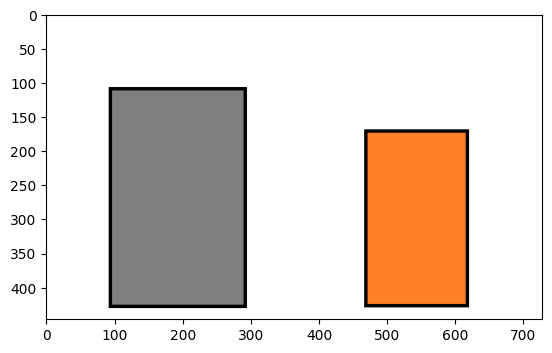

In [44]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

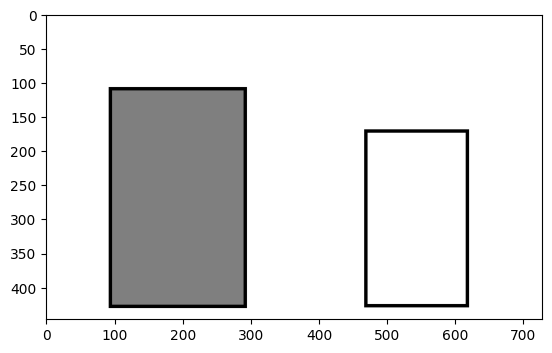

In [45]:
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = img[:, :, 0]
plt.imshow(gray, cmap="grey")

In [46]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)

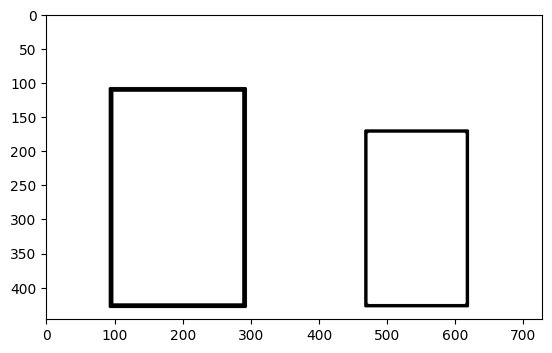

In [47]:
retval, thresh = cv2.threshold(blur, 125, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap="grey")

<Axes: xlabel='x', ylabel='y'>

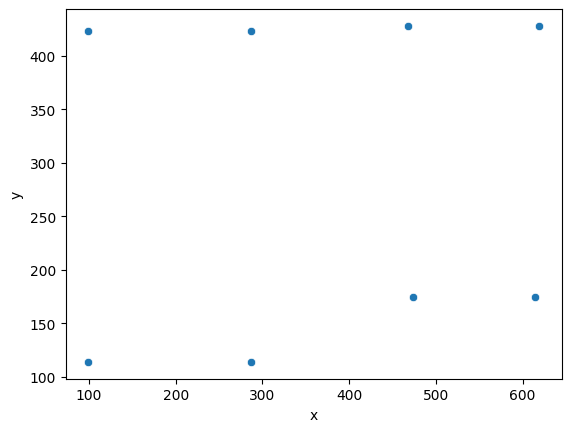

In [48]:
corners = cv2.goodFeaturesToTrack(thresh, 100, 0.01, 50)
cors = []
for corner in corners:
    x, y = corner[0]
    cors.append([x, y])

cors = pd.DataFrame(cors, columns=["x", "y"])
sns.scatterplot(cors, x="x", y="y")
# for corner in corners:
#     x, y = corner[0]
#     x = int(x)
#     y = int(y)
#     cv2.rectangle(img, (x - 10, y - 10), (x + 10, y + 10), (255, 0, 0), -1)


# cv2.imwrite('Corner_detected_rectangles.png', img)
# cv2.imshow(thresh)

In [69]:
preproc_img = preprocess_image(img)
plt.imshow(preproc_img, cmap="grey")

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [52]:
preproc_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [76]:
cnts, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [61]:
hier

array([[[ -1,  -1,   1,  -1],
        [  2,  -1,  -1,   0],
        [  3,   1,  -1,   0],
        ...,
        [ -1,  -1,  -1, 250],
        [253, 246,  -1, 107],
        [ -1, 252,  -1, 107]]], dtype=int32)

In [54]:
cnts_sort, cnt_is_card = find_cards(preproc_img)

In [ ]:
if len(cnts_sort) != 0:
    # Initialize a new "cards" list to assign the card objects.
    # k indexes the newly made array of cards.
    cards = []
    k = 0

    # For each contour detected:
    for i in range(len(cnts_sort)):
        if cnt_is_card[i] == 1:
            # Create a card object from the contour and append it to the list of cards.
            # preprocess_card function takes the card contour and contour and
            # determines the cards properties (corner points, etc). It generates a
            # flattened 200x300 image of the card, and isolates the card's
            # suit and rank from the image.
            cards.append(preprocess_card(cnts_sort[i], image))

            # Find the best rank and suit match for the card.
            (
                cards[k].best_rank_match,
                cards[k].best_suit_match,
                cards[k].rank_diff,
                cards[k].suit_diff,
            ) = Cards.match_card(cards[k], train_ranks, train_suits)

            # Draw center point and match result on the image.
            image = draw_results(image, cards[k])
            k = k + 1